In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import re
from xgboost import XGBClassifier

In [68]:
df=pd.read_csv('games.csv')

Exploratory Data Analysis

In [70]:
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [71]:
df.shape

(20058, 16)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [73]:
df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


Create Visuals to understand the distributions and relationships between variables

<AxesSubplot:>

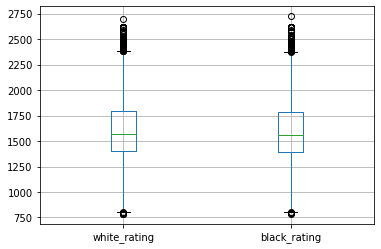

In [74]:
#Plot white and black rating box plots to validate similar distributions
pd.plotting.boxplot(df[['winner','white_rating','black_rating']])

White rating and black rating have very similar distributions, as expected from a system that pairs like-skilled players against each other. The majority of both black and white players lie within the 1000-2000 rating range.

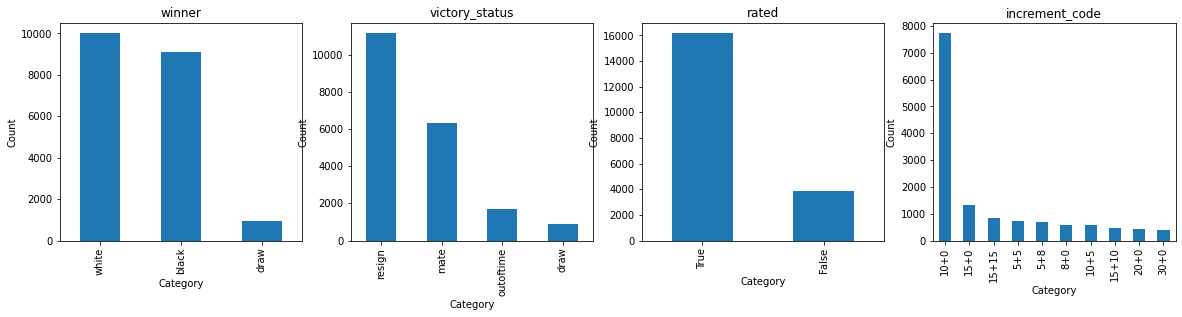

In [75]:
# Create bar chars to display frequency of categorical featues

# Counts of occurrences (use top 10 increment codes for now)
count_winner = df['winner'].value_counts()
count_victory_status = df['victory_status'].value_counts()
count_rated = df['rated'].value_counts()
count_increment_code = df['increment_code'].value_counts().head(10)

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# Plot bar charts for each category
count_winner.plot(kind='bar', ax=axes[0])
axes[0].set_title('winner')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')

count_victory_status.plot(kind='bar', ax=axes[1])
axes[1].set_title('victory_status')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')

count_rated.plot(kind='bar', ax=axes[2])
axes[2].set_title('rated')
axes[2].set_xlabel('Category')
axes[2].set_ylabel('Count')

count_increment_code.plot(kind='bar', ax=axes[3])
axes[3].set_title('increment_code')
axes[3].set_xlabel('Category')
axes[3].set_ylabel('Count')

plt.show()

White and black have a similar number of wins, with draws being a small portion of the data. The majority of games played were rated and end in either a resignation (common when the game seems past the point of being winnable) or by mate. There are many different increments, although 10+0 is by far the most common. I will split this feature into two pieces - the initial game length (10 minutes for the 10+0 case) and increment or the amount of time that gets added each turn (0 in the case of 10+0)

In [76]:
#Split up increment code into initial game length and increment time
df['game_length']=df['increment_code'].map(lambda x: int(x.split('+', 1)[0]))
df['increment']=df['increment_code'].map(lambda x: int(x.split('+', 1)[1]))
print(f"Number of distinct game lengths: {df['game_length'].nunique()}")
print(f"Number of distinct increments: {df['increment'].nunique()}")


Number of distinct game lengths: 33
Number of distinct increments: 32


array([[<AxesSubplot:xlabel='turns', ylabel='turns'>,
        <AxesSubplot:xlabel='white_rating', ylabel='turns'>,
        <AxesSubplot:xlabel='black_rating', ylabel='turns'>,
        <AxesSubplot:xlabel='game_length', ylabel='turns'>,
        <AxesSubplot:xlabel='increment', ylabel='turns'>],
       [<AxesSubplot:xlabel='turns', ylabel='white_rating'>,
        <AxesSubplot:xlabel='white_rating', ylabel='white_rating'>,
        <AxesSubplot:xlabel='black_rating', ylabel='white_rating'>,
        <AxesSubplot:xlabel='game_length', ylabel='white_rating'>,
        <AxesSubplot:xlabel='increment', ylabel='white_rating'>],
       [<AxesSubplot:xlabel='turns', ylabel='black_rating'>,
        <AxesSubplot:xlabel='white_rating', ylabel='black_rating'>,
        <AxesSubplot:xlabel='black_rating', ylabel='black_rating'>,
        <AxesSubplot:xlabel='game_length', ylabel='black_rating'>,
        <AxesSubplot:xlabel='increment', ylabel='black_rating'>],
       [<AxesSubplot:xlabel='turns', ylabel='

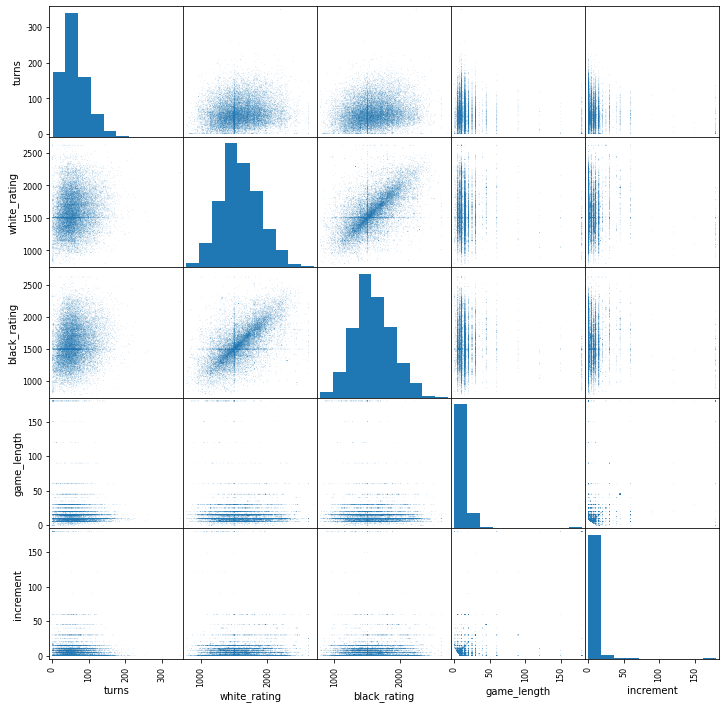

In [77]:
#Create scatte matrix to visualize numeric features and their relation to each other
pd.plotting.scatter_matrix(df[['turns','white_rating','black_rating','game_length','increment']],s=1,figsize=(12,12))

White and black rating are heavily correlated, as would be expected. We will want to use only one of these, as well as a separate variable measuring the difference between the two, when creating a predictive model here

In [78]:
#Look at the top opening names to validate them
df['opening_name'].value_counts().head(20)

Van't Kruijs Opening                             368
Sicilian Defense                                 358
Sicilian Defense: Bowdler Attack                 296
Scotch Game                                      271
French Defense: Knight Variation                 271
Scandinavian Defense: Mieses-Kotroc Variation    259
Queen's Pawn Game: Mason Attack                  232
Queen's Pawn Game: Chigorin Variation            229
Scandinavian Defense                             223
Horwitz Defense                                  209
Caro-Kann Defense                                199
Philidor Defense #3                              198
Philidor Defense #2                              193
Indian Game                                      181
Italian Game: Anti-Fried Liver Defense           180
Four Knights Game: Italian Variation             176
Modern Defense                                   174
Owen Defense                                     168
King's Pawn Game: Wayward Queen Attack        

Van't Kruijs Opening is not a common opening. It appears to be the default value (denoted as A00) for when an otherwise uncategorized opening is played. We can leave this as-is, since having no defined opening can be treated an opening in iteself

Next, we group similar openings by combining different variations i.e. Sicilian Defense and Sicilian Defense: Bowdler Attack. This will help with reducing the number of features with low frequency

In [79]:
#Remove all text after : or | characters (typically used to indicate variations)
def group_openings_1(string):
    if ':' in string:
        return string.split(':', 1)[0].strip()
    elif '|' in string:
        return string.split('|', 1)[0].strip()
    else:
        return string

#Use regex to return only the string up to and including the following strings
def group_openings_2(string):
    pattern = r'^(.*?(?:Defense|Attack|Game|Opening|Gambit|Countergambit)\b)'
    match = re.match(pattern, string)
    if match:
        return match.group(1)
    else:
        return string


In [80]:
#Apply above functions to map the openings
df['opening_group']=df['opening_name'].map(group_openings_1).map(group_openings_2)
opening_count=df['opening_group'].nunique()
print(f"Total number of openings after grouping: {opening_count} ")

Total number of openings after grouping: 128 


In [81]:
#Create feature mappings for the rating difference between white and black depending on the game outcome
df['rating_diff_w']=df.apply(lambda row: row['white_rating']-row['black_rating'] if row['winner']=='white' else None,axis=1)
df['rating_diff_b']=df.apply(lambda row: row['white_rating']-row['black_rating'] if row['winner']=='black' else None,axis=1)
df['rating_diff_d']=df.apply(lambda row: row['white_rating']-row['black_rating'] if row['winner']=='draw' else None,axis=1)
df['rating_diff']=df.apply(lambda row: row['white_rating']-row['black_rating'],axis=1)
df['white_win']=df.apply(lambda row: 1 if row['winner']=='white' else 0,axis=1)
df['black_win']=df.apply(lambda row: 1 if row['winner']=='black' else 0,axis=1)
df['draw']=df.apply(lambda row: 1 if row['winner']=='draw' else 0,axis=1)



In [82]:
# Look at the mean and median rating difference in the case where either side wins as well as a draw

print(f" Mean rating difference when white wins is {df.rating_diff_w.mean(): .2f}")
print(f" Median rating difference when white wins is {df.rating_diff_w.median()}")

print(f" Mean rating difference when black wins is {df.rating_diff_b.mean(): .2f}")
print(f" Median rating difference when black wins is {df.rating_diff_b.median()}")

print(f" Mean rating difference when draw is {df.rating_diff_d.mean(): .2f}")
print(f" Median rating difference when draw is {df.rating_diff_d.median()}")

 Mean rating difference when white wins is  95.31
 Median rating difference when white wins is 59.0
 Mean rating difference when black wins is -88.98
 Median rating difference when black wins is -52.0
 Mean rating difference when draw is  14.35
 Median rating difference when draw is 0.0


(array([  2.,   0.,   3.,   0.,   3.,   0.,   1.,   3.,   2.,   4.,   4.,
         6.,   7.,  11.,  19.,  25.,  27.,  40.,  44.,  65.,  93., 101.,
       117.,  79.,  63.,  49.,  34.,  24.,  25.,  19.,  11.,   6.,  10.,
         6.,  16.,   5.,   9.,   1.,   4.,   2.,   0.,   2.,   3.,   2.,
         1.,   0.,   0.,   0.,   1.,   1.]), array([-810.  , -773.32, -736.64, -699.96, -663.28, -626.6 , -589.92,
       -553.24, -516.56, -479.88, -443.2 , -406.52, -369.84, -333.16,
       -296.48, -259.8 , -223.12, -186.44, -149.76, -113.08,  -76.4 ,
        -39.72,   -3.04,   33.64,   70.32,  107.  ,  143.68,  180.36,
        217.04,  253.72,  290.4 ,  327.08,  363.76,  400.44,  437.12,
        473.8 ,  510.48,  547.16,  583.84,  620.52,  657.2 ,  693.88,
        730.56,  767.24,  803.92,  840.6 ,  877.28,  913.96,  950.64,
        987.32, 1024.  ]), <BarContainer object of 50 artists>)


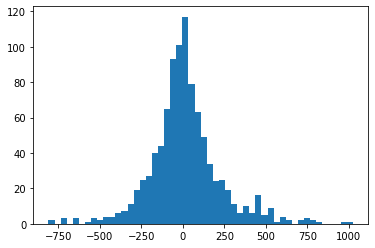

In [83]:
# Print the difference in rating for games that results in a draw. Interestingly, this is slightly skewed right
print(plt.hist(df['rating_diff_d'], bins=50))

Now that we have a basic undersunderstanding of the various features within this dataset, we can begin answerering the first question of how well are we able to predict the ultimate winner of a match. Since the difference in rating is the most obvious predictor here, the real test is to see if we can do better than just using rating diff for prediction. In other words, the challenge is to see how much if any additional information can we use about a given game to make a more accurate prediciton of the winner. 

To do this, we can first create a simple logistic regression using only rating diff in order to get a baseline accuracy to beat. For now, we will be removing draws in order to simplify this into a binary classification problem.

In [84]:
#First, remove games that result in a draw

df=df.loc[df['victory_status'] != 'draw']
df.reset_index(drop=True,inplace=True)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df.rating_diff, df.white_win, test_size=0.25, random_state=0)
X_train=X_train.array.reshape(-1, 1)
X_test=X_test.array.reshape(-1, 1)

In [86]:
LR=LogisticRegression()
LR.fit(X_train,y_train)
predict=LR.predict(X_test)
train_score=LR.score(X_test, y_test)
score=LR.score(X_test, y_test)
print(f"Initial Logistic Regression Training Accuracy: {train_score:.2f}%")
print(f"Initial Logistic Regression Test Accuracy: {score:.2f}%")

Initial Logistic Regression Training Accuracy: 0.65%
Initial Logistic Regression Test Accuracy: 0.65%


In [87]:
print(metrics.confusion_matrix(y_test,predict))


[[1340  943]
 [ 753 1752]]


In [88]:
#Because the viscory status is very balanced, prediction accuracy is a good performance metric here, but its also worth looking at other diagnostics such as the confusion matrix and f1 score in order to validate that
f1_score=metrics.f1_score(y_test,predict)
print(f"Initial Logistic Regression Test F1: {f1_score:.2f}%")


Initial Logistic Regression Test F1: 0.67%


As expected, the differene in rating alone is a decent predictor of the winner. The next step will to see how much better (if at all) of a model we can create utilizing the full set of features available

In [89]:
#Use one-hot encoding for categorical features
enc = OneHotEncoder()
df_enc= enc.fit_transform(df[['opening_group','rated','victory_status']])
df_enc=pd.DataFrame(df_enc.toarray(),columns=enc.get_feature_names_out())
df=pd.concat([df,df_enc],axis=1)

In [90]:
cols=['rating_diff','white_rating','turns','game_length','increment']
enc_cols=[i for i in enc.get_feature_names_out()]
cols.extend(enc_cols)

In [91]:
#Print the full set of features after encoding
print(cols)

['rating_diff', 'white_rating', 'turns', 'game_length', 'increment', 'opening_group_Alekhine Defense', 'opening_group_Amar Opening', 'opening_group_Amazon Attack', 'opening_group_Anderssen Opening', 'opening_group_Australian Defense', 'opening_group_Barnes Defense', 'opening_group_Barnes Opening', 'opening_group_Benko Gambit', 'opening_group_Benoni Defense', 'opening_group_Bird Opening', "opening_group_Bishop's Opening", 'opening_group_Blackmar-Diemer Gambit', 'opening_group_Blumenfeld Countergambit', 'opening_group_Bogo-Indian Defense', 'opening_group_Borg Defense', 'opening_group_Budapest Defense', 'opening_group_Canard Opening', 'opening_group_Caro-Kann Defense', 'opening_group_Carr Defense', 'opening_group_Catalan Opening', 'opening_group_Center Game', 'opening_group_Clemenz Opening', 'opening_group_Colle System', 'opening_group_Colle System #2', 'opening_group_Crab Opening', 'opening_group_Creepy Crawly Formation', 'opening_group_Czech Defense', 'opening_group_Danish Gambit', 'ope

In [93]:
#Create new training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[cols], df.white_win, test_size=0.25, random_state=0)

In [122]:
#Create random forest model 
RF=RandomForestClassifier(max_depth=50,min_samples_split=20,max_samples=0.5)
RF.fit(X_train,y_train)
predict=RF.predict(X_test)
train_score=RF.score(X_train, y_train)
score=RF.score(X_test, y_test)
print(f"Random Forest Training Accuracy: {train_score:.2f}%")
print(f"Random Forest Test Accuracy: {score:.2f}%")


Random Forest Training Accuracy: 0.80%
Random Forest Test Accuracy: 0.68%


In [123]:
# Get feature importance scores of the model
feature_scores = RF.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_scores})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance.head(10))

                          Feature  Importance
0                     rating_diff    0.347415
2                           turns    0.122168
1                    white_rating    0.120703
3                     game_length    0.050720
4                       increment    0.041346
135           victory_status_mate    0.008779
137         victory_status_resign    0.008444
57     opening_group_Italian Game    0.008310
43   opening_group_French Defense    0.007942
134                    rated_True    0.007846


Note that rating difference is still the most important feature in this model based on gini impurity

Hyperparameter tuning on the random forest model can reduce the level of overfitting seen here, but it is not able to produce a much higher accuracy than the initial logistic regression model. This indicates that it is not really learning the underlying structure of the data better than the logistic regression model. Creating another logistic regression model with the same set of features results in a similar test accuracy. 

In order to create a model that does effectively learn from the large set of features here, we can rely on a gradient boosted tree model.

In [ ]:
#Create a Gradient boosted tree model using XGBoost using GridSearchCV to find optimal hyperparameters
xgb = XGBClassifier()

param_grid = {
    'max_depth': [3, 5, 8, 13],              
    'min_child_weight': [1, 3, 5, 7],         
    'gamma': [0, 0.1, 1],               
    'subsample': [0.8, 0.9],              
    'colsample_bytree': [0.8, 0.9]       
}

grid_search = GridSearchCV(xgb, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)

train_score=best_xgb_model.score(X_train, y_train)
test_score=best_xgb_model.score(X_test, y_test)

print(f"XGBoost Training Accuracy: {train_score:.2f}%")
print(f"XGBoost Test Accuracy: {test_score:.2f}%")

XGBoost Training Accuracy: 0.95%
XGBoost Test Accuracy: 0.87%


In [ ]:
#Print parameters of best cross-validated model
params=best_xgb_model.get_params()
param_list=['max_depth','min_child_weight','gamma','subsample','colsample_bytree']
for p in param_list:
    param_temp=params[p]
    print(f"{p} : {param_temp}")

max_depth : 8
min_child_weight : 1
gamma : 1
subsample : 0.9
colsample_bytree : 0.9


In [ ]:
# Get feature importance scores of the model
feature_scores = best_xgb_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_scores})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance.head(10))

                                Feature  Importance
2                                 turns    0.050963
0                           rating_diff    0.036333
126  opening_group_Van't Kruijs Opening    0.030692
122          opening_group_Torre Attack    0.029221
37        opening_group_Elephant Gambit    0.024019
54      opening_group_Hungarian Opening    0.021628
49      opening_group_Gruenfeld Defense    0.020931
55            opening_group_Indian Game    0.020125
115          opening_group_Slav Defense    0.019092
125      opening_group_Van Geet Opening    0.018765


XGBoost is able to produce a significantly better accuracy than random forest. This is likely due to the relatively large number of one-hot encoded features, which create a sparse feature matrix. While boosted models can be difficult to interpret, it looks like "turns" is being considered much more heavily here compared to the random forest model. This is evident from both the weight feature importance seen here, as well as gain and cover metrics.


The next step will be to introduce the chess engine Stockfish to assess the relative advantage at different stages of the game based on the moves that have been made up to that point. The two main goals of this are to see if we can use this to create a better model for predicting the final outcome of the game, and to understand its relative importance in relation to other features such as rating, opening, and number of turns.